In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import json
import sklearn 
import sklearn.decomposition
import sklearn.manifold
import numpy as np
import pandas as pd

In [2]:
fname = '../embeddings/cifar_100_davinci-001.json'
with open(fname, 'r') as f:
    embeddings = json.load(f)

In [3]:
X = np.asarray(list(embeddings.values()))

In [4]:
pca = sklearn.manifold.TSNE(n_components=2, learning_rate='auto', init='random')
#pca = sklearn.decomposition.PCA(n_components=2)
transformed = pca.fit_transform(X)

In [6]:
df = pd.DataFrame(transformed)

In [7]:
df = df.rename(columns={0: "x1", 1: "x2"})

In [8]:
df

,x1,x2
0,-7.805197,1.109795
1,-6.945257,-1.220463
2,-7.650654,0.520888
3,-5.670148,0.563328
4,-6.642484,-0.977556
...,...,...
95,-1.961535,-5.058791
96,-0.043254,5.226059
97,-0.645239,9.650981
98,0.131890,4.863163


In [9]:
groups = 5*[0] + 5*[1] + 5*[2] + 5*[3] + 5*[4] + 5*[5] + 5*[6] + 5*[7] + 5*[8] + 5*[9] 
groups += 5*[10] + 5*[11] + 5*[12] + 5*[13] + 5*[14] + 5*[15] + 5*[16] + 5*[17] + 5*[18] + 5*[19]
names = list(embeddings.keys())


/home/chrisw/miniconda3/envs/openai/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


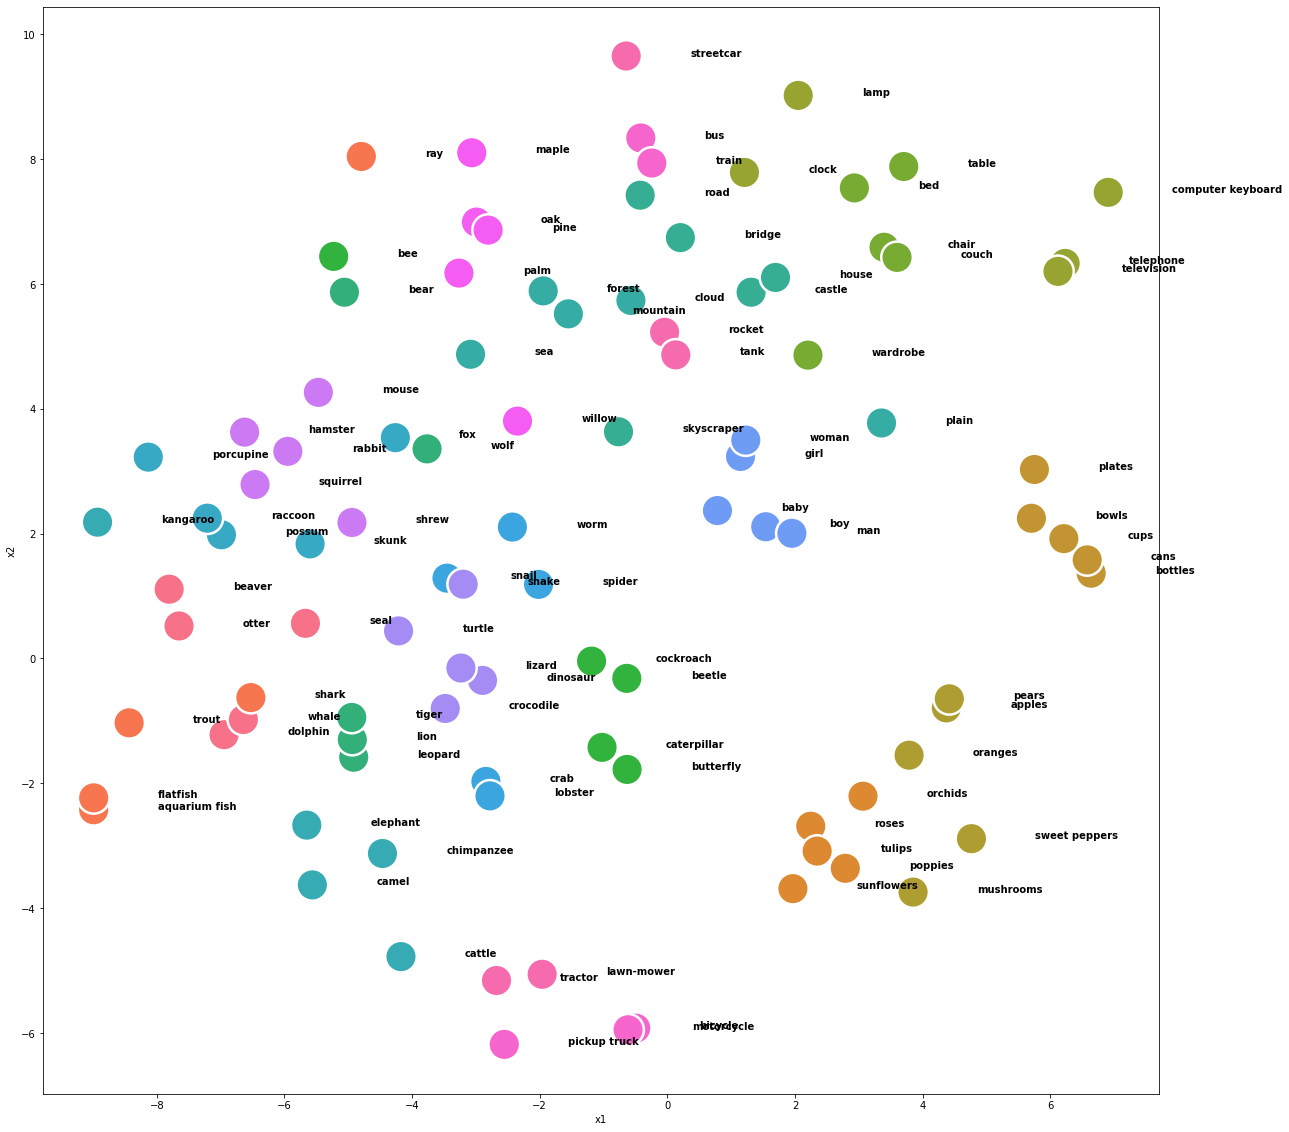

In [10]:
plt.figure(figsize=(20,20))
p1 = sns.scatterplot('x1', # Horizontal axis
       'x2', # Vertical axis
       hue=groups,
       data=df, # Data source
       legend=False, 
       s=1000,
       palette=sns.color_palette("husl", 20))  

for line in range(0,df.shape[0]):
     p1.text(df.x1[line]+1, df.x2[line], 
     names[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

# Set x-axis label
plt.xlabel('x1')
# Set y-axis label
plt.ylabel('x2')
plt.savefig('../results/cifar100_tsne.pdf')